In [ ]:
!pip install transformers xgboost scikit-learn matplotlib seaborn

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

In [ ]:
df = pd.read_csv("linkedin_profiles.csv")

In [ ]:
df["Profile_Text"] = (
    df["Industry"] + " " + df["Designation"] + " " + df["Location"]
)

In [ ]:
df.head()

,Industry,Designation,Location,Valid_Display_Picture,Post_Frequency,Connections_Above_300,Headline_Relevant,About_Filled,Featured_Section_Used,Activity_Tab_Active,...,Seniority_Level_Relevant,Location_Match,Has_External_Links,Has_Skills_Endorsements,Education_Filled,Has_Recommendations,Company_Has_Linkedin,Creator_Mode_On,is_high_quality,Profile_Text
0,Healthcare,CTO,Bangalore,0,1,1,1,0,1,0,...,0,1,1,1,1,1,1,0,0,Healthcare CTO Bangalore
1,Marketing,CEO,Berlin,1,1,1,0,1,0,0,...,0,0,0,1,1,1,0,1,1,Marketing CEO Berlin
2,Healthcare,CEO,San Francisco,1,1,1,1,0,1,0,...,1,0,0,0,0,0,1,0,0,Healthcare CEO San Francisco
3,Marketing,Manager,London,1,1,0,0,0,0,1,...,0,0,1,1,1,0,1,1,0,Marketing Manager London
4,Tech,Manager,Berlin,1,1,1,1,0,1,1,...,0,0,1,1,1,0,1,0,1,Tech Manager Berlin


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
inputs = tokenizer(
    list(df["Profile_Text"]),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=32
)

In [ ]:
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states

In [ ]:
fused_embedding = torch.stack(hidden_states[-4:]).mean(0)[:, 0, :]
X_bert = fused_embedding.numpy()

In [ ]:
y = df["is_high_quality"].values
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer.save_pretrained("bert_tokenizer")
model.save_pretrained("bert_model")
print("BERT model and tokenizer saved successfully!")

BERT model and tokenizer saved successfully!


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

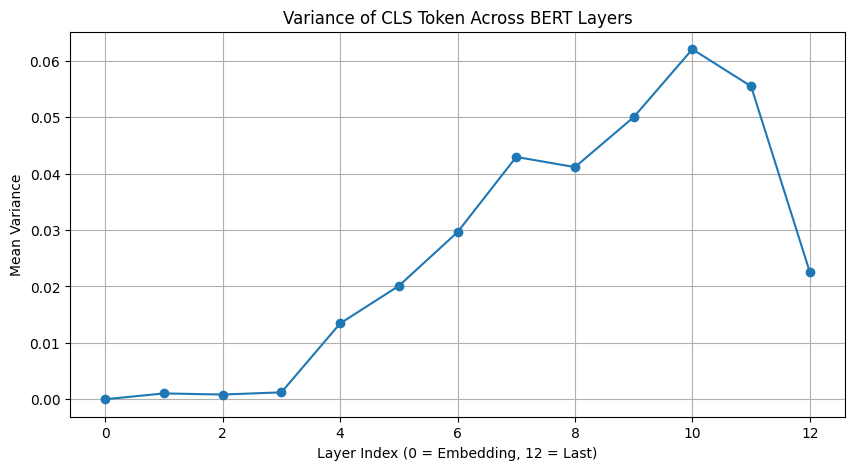

In [ ]:
layer_means = []

for i, layer in enumerate(hidden_states):
    cls_vec = layer[:, 0, :].numpy()
    mean_variance = np.var(cls_vec, axis=0).mean()
    layer_means.append(mean_variance)

plt.figure(figsize=(10, 5))
plt.plot(range(len(layer_means)), layer_means, marker="o")
plt.title("Variance of CLS Token Across BERT Layers")
plt.xlabel("Layer Index (0 = Embedding, 12 = Last)")
plt.ylabel("Mean Variance")
plt.grid(True)
plt.show()


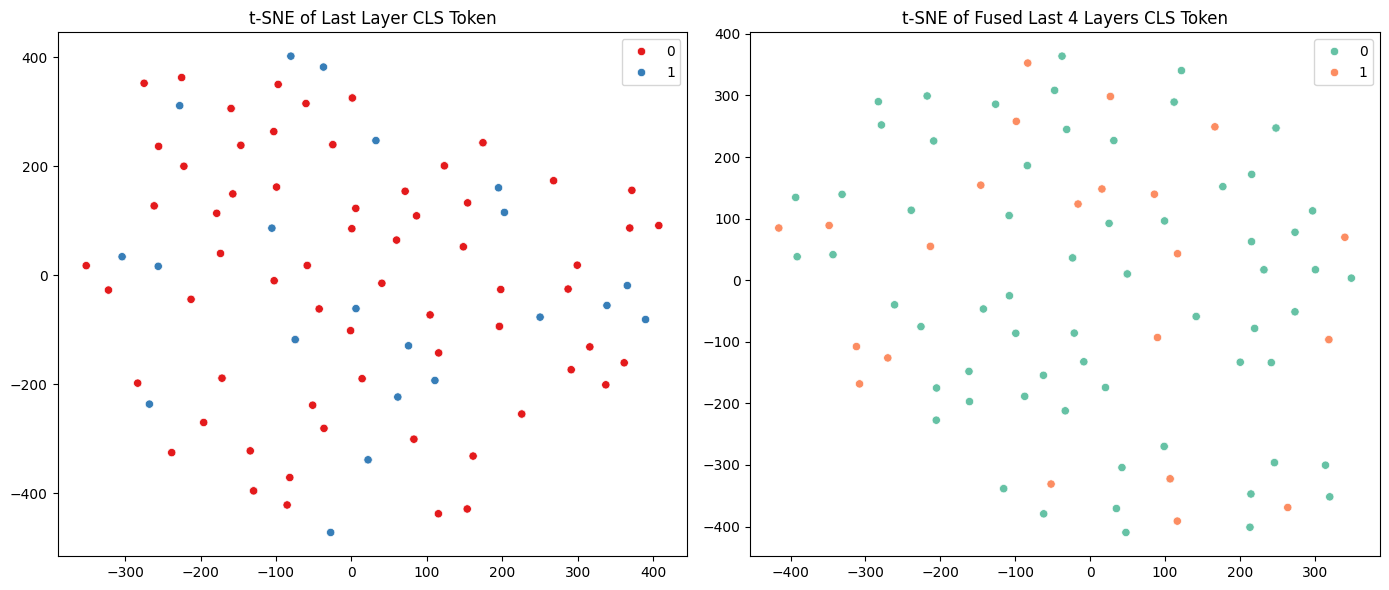

In [ ]:
from sklearn.manifold import TSNE
last_layer_cls = hidden_states[-1][:, 0, :].numpy()
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_fused = tsne.fit_transform(X_bert)
tsne_last = tsne.fit_transform(last_layer_cls)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(x=tsne_last[:, 0], y=tsne_last[:, 1], hue=y, ax=axes[0], palette="Set1")
axes[0].set_title("t-SNE of Last Layer CLS Token")

sns.scatterplot(x=tsne_fused[:, 0], y=tsne_fused[:, 1], hue=y, ax=axes[1], palette="Set2")
axes[1].set_title("t-SNE of Fused Last 4 Layers CLS Token")

plt.tight_layout()
plt.show()


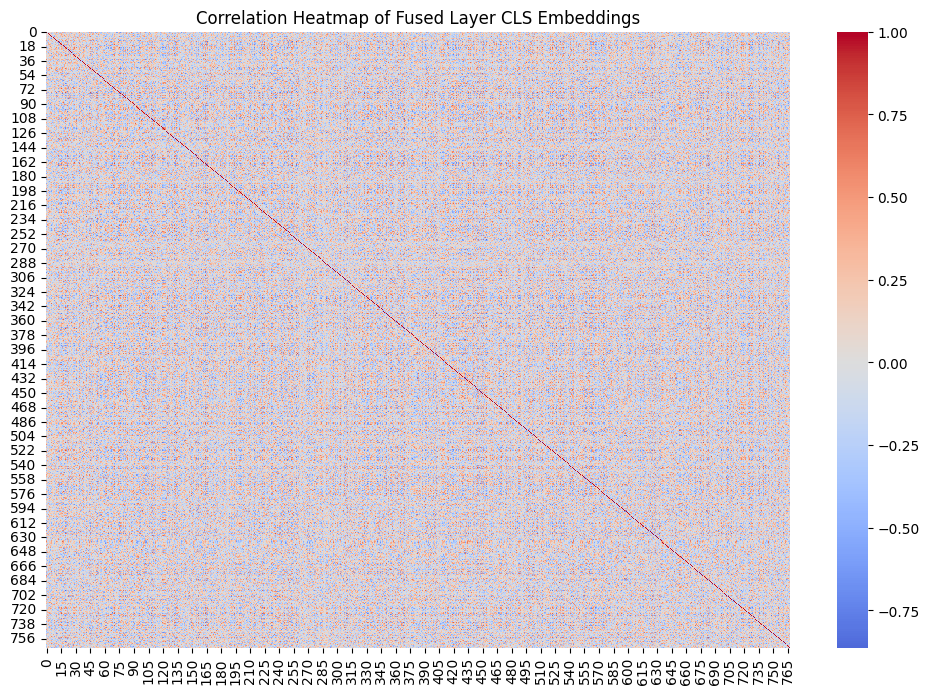

In [ ]:
import seaborn as sns

corr_matrix = np.corrcoef(X_bert.T)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Fused Layer CLS Embeddings")
plt.show()

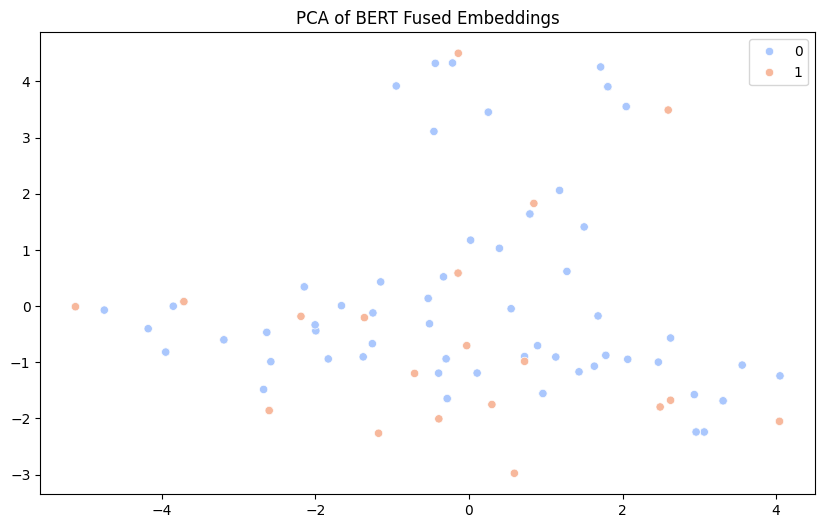

In [ ]:
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_bert)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=y, palette="coolwarm")
plt.title("PCA of BERT Fused Embeddings")
plt.show()

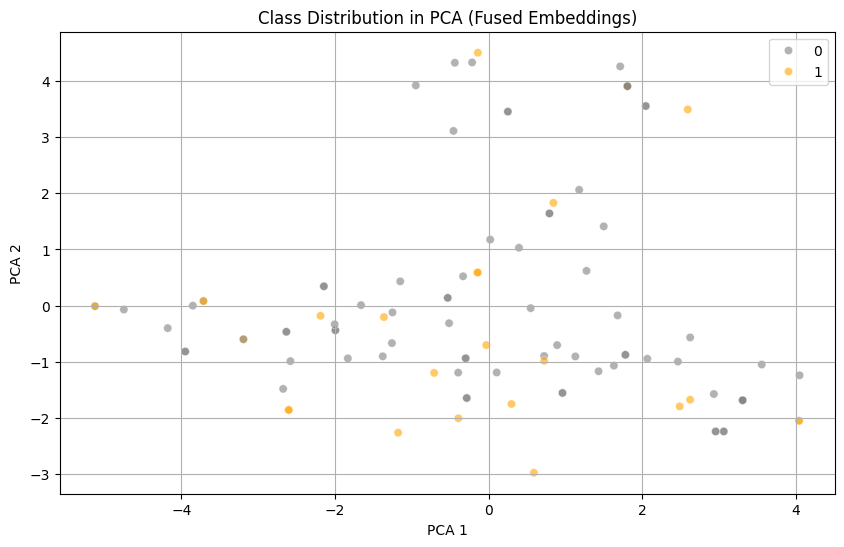

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y, palette={0: "gray", 1: "orange"}, alpha=0.6)
plt.title("Class Distribution in PCA (Fused Embeddings)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

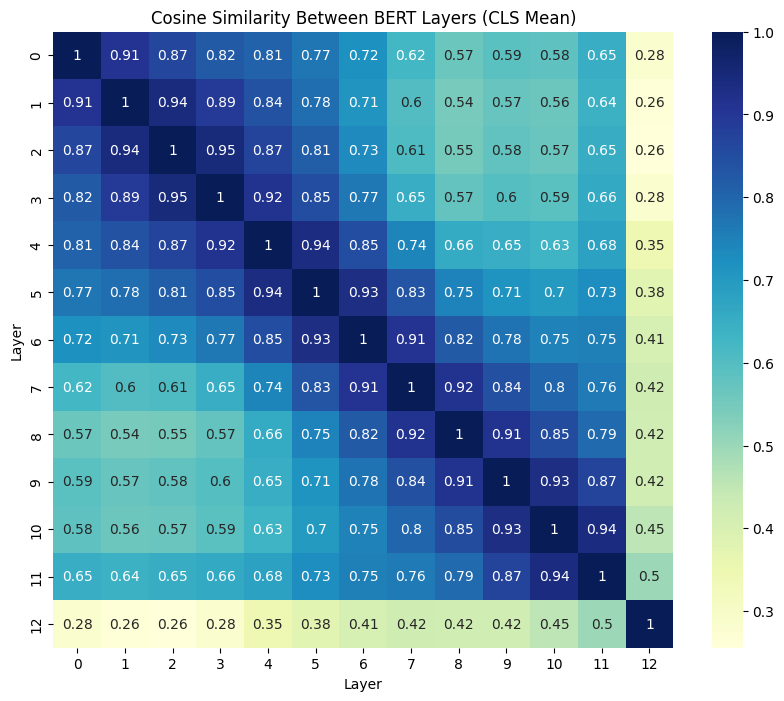

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

layer_cls = [layer[:, 0, :].numpy().mean(axis=0) for layer in hidden_states]
sim_matrix = cosine_similarity(layer_cls)

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, annot=True, cmap="YlGnBu")
plt.title("Cosine Similarity Between BERT Layers (CLS Mean)")
plt.xlabel("Layer")
plt.ylabel("Layer")
plt.show()


In [ ]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
def custom_eval_metric(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = (preds > 0.5).astype(int)
    precision = precision_score(labels, preds_binary)
    recall = recall_score(labels, preds_binary)
    f1 = f1_score(labels, preds_binary)
    return [('precision', precision), ('recall', recall), ('f1', f1), ('penalty_fp', -sum((preds_binary - labels) > 0) / len(labels))]

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.05,
    'max_depth': 5,
    'scale_pos_weight': 0.7
}

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'test')],
    feval=custom_eval_metric,
    maximize=True,
    early_stopping_rounds=10
)

[0]	test-logloss:0.70647	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[1]	test-logloss:0.70780	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[2]	test-logloss:0.71068	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[3]	test-logloss:0.71118	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[4]	test-logloss:0.71415	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

[5]	test-logloss:0.71623	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[6]	test-logloss:0.72266	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[7]	test-logloss:0.72861	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[8]	test-logloss:0.73124	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[9]	test-logloss:0.73511	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000
[10]	test-logloss:0.73627	test-precision:0.00000	test-recall:0.00000	test-f1:0.00000	test-penalty_fp:0.00000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
y_prob = model.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.96      0.98      0.97        47

    accuracy                           0.96        68
   macro avg       0.95      0.94      0.95        68
weighted avg       0.96      0.96      0.96        68



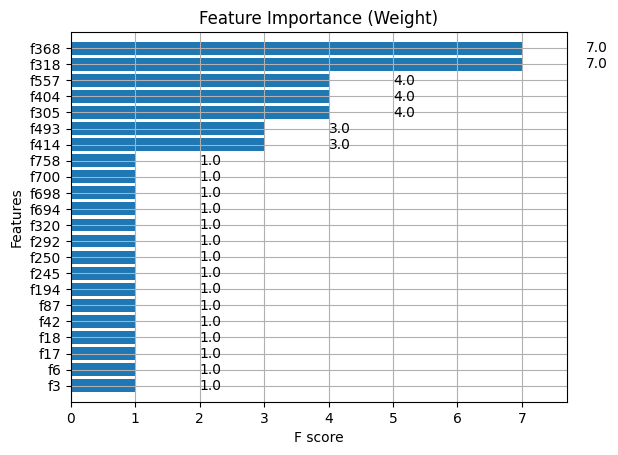

In [ ]:
xgb.plot_importance(model, importance_type='weight', title="Feature Importance (Weight)", height=0.8)
plt.show()

In [ ]:
model.save_model('xgboost_model.json')